In [1]:
# docker run -p 8888:8888 -p 4040:4040 -v "%cd%:/home/jovyan/work" quay.io/jupyter/pyspark-notebook

In [25]:
from pyspark.sql import SparkSession
from pyspark.sql.window import Window
import pyspark.sql.functions as F

from pyspark.sql.functions import col, sin, cos, lit
import math

import itertools
from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.tsa.arima.model import ARIMA

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import GridSearchCV

import matplotlib.pyplot as plt

import pandas as pd

In [3]:
spark = SparkSession.builder.appName("SeriesTemporales").getOrCreate()
# Leer archivo Parquet
df = spark.read.parquet("../../../data/transformed/madrid_data/parquet/")
df = df.orderBy(["fecha", "hora"])
# Mostrar datos
df.groupBy("anho").count().show()

+----+-----+
|anho|count|
+----+-----+
|2023| 8760|
|2022| 8760|
|2020| 8784|
|2021| 8760|
|2019| 8760|
|2024| 8784|
|2025| 1393|
+----+-----+



In [4]:
# Definir ventana para obtener las 3 horas anteriores
window_lag = Window.partitionBy("indicativo", "anho", "mes", "dia").orderBy("hora")

# Agregar columnas de las 3 horas previas
df = df.withColumn("temp_hora_1", F.lag("temperatura_media", 1).over(window_lag)) \
       .withColumn("temp_hora_2", F.lag("temperatura_media", 2).over(window_lag)) \
       .withColumn("temp_hora_3", F.lag("temperatura_media", 3).over(window_lag))

In [5]:
# Calcular temperatura general por hora, día y mes en todo el DataFrame
df_temp_stats = df.groupBy("hora", "dia", "mes").agg(
    F.avg("temperatura_media").alias("temp_media_general"),
    F.min("temperatura_media").alias("temp_min_general"),
    F.max("temperatura_media").alias("temp_max_general")
)
# Unir las estadísticas generales al DataFrame original
df = df.join(df_temp_stats, on=["hora", "dia", "mes"], how="left")

In [6]:
df = df.filter(df["anho"] >= 2023)
df.show(20, truncate=False)

+----+---+---+----------+-------------+-----------------+----------+----+-----------+-----------+-----------+------------------+----------------+----------------+
|hora|dia|mes|fecha     |humedad_media|temperatura_media|indicativo|anho|temp_hora_1|temp_hora_2|temp_hora_3|temp_media_general|temp_min_general|temp_max_general|
+----+---+---+----------+-------------+-----------------+----------+----+-----------+-----------+-----------+------------------+----------------+----------------+
|0   |1  |1  |2023-01-01|72.0         |3.4              |102       |2023|NULL       |NULL       |NULL       |3.4285714285714284|0.6             |6.9             |
|1   |1  |1  |2023-01-01|72.0         |3.0              |102       |2023|3.4        |NULL       |NULL       |3.0               |0.6             |6.3             |
|10  |1  |1  |2023-01-01|60.7         |4.0              |102       |2023|3.0        |3.4        |NULL       |3.9857142857142853|1.9             |8.6             |
|11  |1  |1  |2023-01-

In [7]:
# Agregar columnas de seno y coseno
df = df.withColumn("hora_sin", sin(2 * math.pi * col("hora") / lit(24)))
df = df.withColumn("hora_cos", cos(2 * math.pi * col("hora") / lit(24)))
df = df.withColumn("dia_sin", sin(2 * math.pi * col("dia") / lit(7)))
df = df.withColumn("dia_cos", cos(2 * math.pi * col("dia") / lit(7)))
df = df.withColumn("mes_sin", sin(2 * math.pi * col("mes") / lit(12)))
df = df.withColumn("mes_cos", cos(2 * math.pi * col("mes") / lit(12)))

df = df.drop("dia", "mes", "humedad_media", "anho")

In [8]:
df.show(20)

+----+----------+-----------------+----------+-----------+-----------+-----------+------------------+----------------+----------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+
|hora|     fecha|temperatura_media|indicativo|temp_hora_1|temp_hora_2|temp_hora_3|temp_media_general|temp_min_general|temp_max_general|            hora_sin|            hora_cos|           dia_sin|           dia_cos|            mes_sin|           mes_cos|
+----+----------+-----------------+----------+-----------+-----------+-----------+------------------+----------------+----------------+--------------------+--------------------+------------------+------------------+-------------------+------------------+
|   0|2023-01-01|              3.4|       102|       NULL|       NULL|       NULL|3.4285714285714284|             0.6|             6.9|                 0.0|                 1.0|0.7818314824680298|0.6234898018587336|0.49999999999999994|

In [9]:
df_pandas = df.toPandas()

In [10]:
df_pandas['fecha'] = pd.to_datetime(df_pandas['fecha'])
df_pandas['hora'] = pd.to_datetime(df_pandas['hora'], format='%H').dt.time


df_pandas = df_pandas.sort_values(by=['fecha', 'hora'])

In [11]:
df_pandas

,hora,fecha,temperatura_media,indicativo,temp_hora_1,temp_hora_2,temp_hora_3,temp_media_general,temp_min_general,temp_max_general,hora_sin,hora_cos,dia_sin,dia_cos,mes_sin,mes_cos
0,00:00:00,2023-01-01,3.4,102,None,None,None,3.428571,0.6,6.9,0.000000,1.000000,7.818315e-01,0.62349,0.500000,0.866025
1,01:00:00,2023-01-01,3.0,102,3.4,None,None,3.000000,0.6,6.3,0.258819,0.965926,7.818315e-01,0.62349,0.500000,0.866025
12,02:00:00,2023-01-01,2.8,102,6.1,6.6,7.6,2.842857,0.4,5.5,0.500000,0.866025,7.818315e-01,0.62349,0.500000,0.866025
17,03:00:00,2023-01-01,2.4,102,3.4,3.8,4.8,2.400000,0.0,5.5,0.707107,0.707107,7.818315e-01,0.62349,0.500000,0.866025
18,04:00:00,2023-01-01,1.8,102,2.4,3.4,3.8,1.771429,-0.1,4.7,0.866025,0.500000,7.818315e-01,0.62349,0.500000,0.866025
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
18757,20:00:00,2025-02-27,8.2,102,3.6,8.7,9.3,8.385714,0.1,8.9,-0.866025,0.500000,-7.818315e-01,0.62349,0.866025,0.500000
18758,21:00:00,2025-02-27,7.6,102,8.2,3.6,8.7,7.871429,-0.2,9.2,-0.707107,0.707107,-7.818315e-01,0.62349,0.866025,0.500000
18759,22:00:00,2025-02-27,6.8,102,7.6,8.2,3.6,7.157143,-0.5,9.9,-0.500000,0.866025,-7.818315e-01,0.62349,0.866025,0.500000
18760,23:00:00,2025-02-27,6.2,102,6.8,7.6,8.2,6.314286,-1.0,8.3,-0.258819,0.965926,-7.818315e-01,0.62349,0.866025,0.500000


In [12]:
def grid_search(y, X):
    # Definir los rangos de p, d, q para buscar
    p = range(0, 4)  # AR terms
    d = range(0, 2)  # Differencing
    q = range(0, 4)  # MA terms
    
    # Generar combinaciones de parámetros
    pdq_combinations = list(itertools.product(p, d, q))
    
    # Almacenar resultados
    best_aic = float("inf")
    best_order = None
    results = []
    
    for order in pdq_combinations:
        try:
            model = SARIMAX(y, exog=X, order=order, trend=None)
            result = model.fit()
            aic = result.aic
            
            results.append((order, aic))
    
            if aic < best_aic:
                best_aic = aic
                best_order = order
    
            print(f"Probando orden {order} - AIC: {aic}")
    
        except Exception as e:
            print(f"Error con orden {order}: {e}")
    return results

In [13]:
def show_graphics(y, forecast):
    # Limitar los datos históricos a los últimos 24 puntos
    historical_data = y[-24:]
    
    # Limitar las predicciones a los primeros 24 puntos
    forecast_data = forecast[:24]
    
    # Graficar los datos históricos (últimos 24 puntos)
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(historical_data)), historical_data, label='Datos históricos', color='blue')
    
    # Graficar las predicciones (primeros 24 puntos)
    plt.plot(range(len(historical_data), len(historical_data) + len(forecast_data)), forecast_data, label='Pronóstico', color='red', linestyle='--')
    
    # Añadir etiquetas y título
    plt.title('Pronóstico con ARIMAX')
    plt.xlabel('Tiempo')
    plt.ylabel('Valor')
    
    # Mostrar leyenda
    plt.legend()
    
    # Mostrar gráfico
    plt.show()

In [14]:
def show_graphics_2(y, forecast):
    plt.figure(figsize=(10, 6))
    plt.plot(y['hora'], y['temperatura_media'], marker='o', linestyle='-')
    plt.plot(y['hora'], forecast, label="Predicción", linestyle="--")
    plt.legend()
    plt.title("Predicciones SARIMAX en Datos de Test")
    plt.show()

In [15]:
train_size = int(len(df_pandas) - 24)
train, test = df_pandas[:train_size], df_pandas[train_size:]

In [16]:
exog_variables = ['hora_sin', 'hora_cos', 'dia_sin', 'dia_cos', 'mes_sin', 'mes_cos']

In [17]:
test

,hora,fecha,temperatura_media,indicativo,temp_hora_1,temp_hora_2,temp_hora_3,temp_media_general,temp_min_general,temp_max_general,hora_sin,hora_cos,dia_sin,dia_cos,mes_sin,mes_cos
18745,01:00:00,2025-02-27,4.6,102,4.7,None,None,4.828571,-1.0,8.8,2.588190e-01,9.659258e-01,-7.818315e-01,0.62349,0.866025,0.5
18756,02:00:00,2025-02-27,3.6,102,8.7,9.3,10.2,4.300000,-1.3,7.7,5.000000e-01,8.660254e-01,-7.818315e-01,0.62349,0.866025,0.5
18761,03:00:00,2025-02-27,3.4,102,6.2,6.8,7.6,3.771429,-1.2,6.0,7.071068e-01,7.071068e-01,-7.818315e-01,0.62349,0.866025,0.5
18762,04:00:00,2025-02-27,3.1,102,3.4,6.2,6.8,3.314286,-1.1,5.5,8.660254e-01,5.000000e-01,-7.818315e-01,0.62349,0.866025,0.5
18763,05:00:00,2025-02-27,2.9,102,3.1,3.4,6.2,3.142857,-1.2,5.4,9.659258e-01,2.588190e-01,-7.818315e-01,0.62349,0.866025,0.5
18764,06:00:00,2025-02-27,2.4,102,2.9,3.1,3.4,3.028571,-1.5,4.9,1.000000e+00,6.123234e-17,-7.818315e-01,0.62349,0.866025,0.5
18765,07:00:00,2025-02-27,1.8,102,2.4,2.9,3.1,2.871429,-2.1,5.4,9.659258e-01,-2.588190e-01,-7.818315e-01,0.62349,0.866025,0.5
18766,08:00:00,2025-02-27,1.8,102,1.8,2.4,2.9,3.414286,-2.4,6.5,8.660254e-01,-5.000000e-01,-7.818315e-01,0.62349,0.866025,0.5
18767,09:00:00,2025-02-27,1.8,102,1.8,1.8,2.4,4.528571,-1.8,7.7,7.071068e-01,-7.071068e-01,-7.818315e-01,0.62349,0.866025,0.5
18746,10:00:00,2025-02-27,1.8,102,4.6,4.7,None,5.442857,-0.7,9.0,5.000000e-01,-8.660254e-01,-7.818315e-01,0.62349,0.866025,0.5


In [18]:
# Variables exógenas
#exog_variables = ['temp_hora_1', 'temp_hora_2', 'temp_hora_3', 'temp_media_general', 'temp_min_general', 'temp_max_general']


# Eliminar valores nulos o rellenar
df_temps = df_pandas.dropna(subset=exog_variables + ['temperatura_media'])
X_train = train[exog_variables]
y_train = train['temperatura_media']

X_test = test[exog_variables]
y_test = test['temperatura_media']


# Asegurarse de que los datos sean numéricos
X_train = X_train.astype(float)
y_train = y_train.astype(float)


In [20]:
#results = grid_search(y, X)
#results = sorted(results, key=lambda x: x[1])
#best_order, best_aic = results[0]
best_order = (3, 1, 3)
#print(f"\nMejor orden encontrado (temps): {best_order} con AIC: {best_aic}")

In [21]:
best_model = SARIMAX(y_train, exog=X_train, order=best_order, seasonal_order=(0, 0, 0, 12))
best_result = best_model.fit()

# Mostrar resumen del modelo
print(best_result.summary())


/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: An unsupported index was provided. As a result, forecasts cannot be generated. To use the model for forecasting, use one of the supported classes of index.
  self._init_dates(dates, freq)
/opt/conda/lib/python3.12/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:      temperatura_media   No. Observations:                18913
Model:               SARIMAX(3, 1, 3)   Log Likelihood              -18930.587
Date:                Sun, 09 Mar 2025   AIC                          37887.174
Time:                        16:12:24   BIC                          37989.192
Sample:                             0   HQIC                         37920.642
                              - 18913                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
hora_sin      -3.8526      0.094    -40.912      0.000      -4.037      -3.668
hora_cos      -0.8488      0.100     -8.478      0.000      -1.045      -0.653
dia_sin       -0.0291      0.033     -0.870      0.3

In [22]:
forecast = best_result.forecast(steps=24, exog=X_train[-24:])

/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/opt/conda/lib/python3.12/site-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


TypeError: float() argument must be a string or a real number, not 'datetime.time'

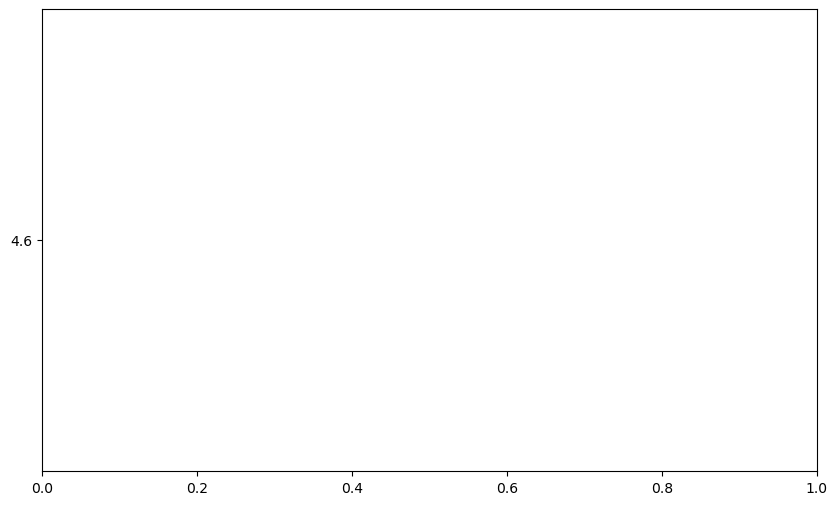

In [23]:
show_graphics_2(test, forecast)

In [26]:
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [10, 20, 30],
    'min_samples_leaf': [1, 2, 4]
}

grid_search = GridSearchCV(estimator=RandomForestRegressor(random_state=42),
                           param_grid=param_grid,
                           cv=5, n_jobs=-1, verbose=2)
grid_search.fit(X_train, y_train)

print(f"Mejores parámetros: {grid_search.best_params_}")

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Mejores parámetros: {'max_depth': 10, 'min_samples_leaf': 4, 'n_estimators': 100}


In [27]:
rf = RandomForestRegressor(n_estimators=100, max_depth=10, min_samples_leaf=4, random_state=42)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=10, min_samples_leaf=4, random_state=42)

In [28]:
y_pred = rf.predict(X_test)

In [29]:
mae = mean_absolute_error(y_test, y_pred)
print(f'Mean Absolute Error: {mae}')

Mean Absolute Error: 0.668961464882251
